# Subplot for the figure on single-cell dynamics
The figure should include 
- typical action potentials observed in cardiomyocites and neurons modelled by the Hodgkin-Huxley model with appropriate parameters.
- simplified, low-dimensional model (FH) with the corresponding phase space underlying action potential dyanamics

In [1]:
using Pkg
Pkg.activate("../")
using DynamicalSystems
using DifferentialEquations
using CairoMakie

  Activating project at `~/git/projects/perspective_heart_and_brain`


In [2]:
Dt = 1e-3 # ms
# implement Connor-Stevens model that is of Hodgkin-Huxley type
# Reference for equations and parametersL Dayan, P., & Abbott, L. F. (2001). Theoretical neuroscience. MIT press. Chapter 6.2 and 6.6.A
# Note: This is intended as an illustration. Efficient and stable implementations should perform analytic solution of the time-evolution of V and gating variables between steps in alternating order (cf. Dayan and Abbott 2001, 5.11.A-B)
function connor_stevens(; 
    # Fig. 5.3 in Dayan and Abbott (2001)
    c_m=10, # nF/mm²
    A=0.1,  # mm²
    # Ch. 6.2 in Dayan and Abbott (2001)
    g_L=0.003, g_Na=1.2, g_K=0.2, g_A=0.477,# mS/mm²
    E_L=-17, E_Na=55, E_K=-72, E_A=-75,# mV
    # for testing
    return_gating_functions=false,
    # for DynamicalSystems
    return_SVector=false,
    )
    # gating variables (maybe there is an issue with the timescale of the gating variables)
    α_m(V) = 0.38 * (V + 29.7) / (1 - exp(-0.1 * (V + 29.7)))
    α_h(V) = 0.266 * exp(-0.05 * (V + 48))
    α_n(V) = 0.02 * (V + 45.7) / (1 - exp(-0.1 * (V + 45.7)))
    β_m(V) = 15.2 * exp(-0.0556 * (V + 54.7))
    β_h(V) = 3.8 / (1 + exp(-0.1 * (V + 18)))
    β_n(V) = 0.25 * exp(-0.0125 * (V + 55.7))

    # rewritten in z_∞ and τ_z
    m_∞(V) = α_m(V) / (α_m(V) + β_m(V))
    τ_m(V) = 1 / (α_m(V) + β_m(V))

    h_∞(V) = α_h(V) / (α_h(V) + β_h(V))
    τ_h(V) = 1 / (α_h(V) + β_h(V))
    
    n_∞(V) = α_n(V) / (α_n(V) + β_n(V))
    τ_n(V) = 1 / (α_n(V) + β_n(V))

    # A current
    a_∞(V) = (0.0761 * exp(0.0314*(V+94.22)) / (1 + exp(0.0346*(V + 1.17))))^(1/3)
    τ_a(V) = 0.3632 + 1.158 / (1 + exp(0.0497*(V + 55.96)))
    b_∞(V) = (1 / (1 + exp(0.0688*(V + 53.3))))^4
    τ_b(V) = 1.24 + 2.678 / (1 + exp(0.0624*(V + 50)))

    function f(u, p, t)
        V, m, h, n, a, b = u
        I_e, = p

        # membrane current
        # standard units: mS/mm² * mV = μA/mm² (S=A/V) 
        i_m = g_L * (V - E_L) + g_Na * m^3 * h * (V - E_Na) + g_K * n^4 * (V - E_K) + g_A * a^3 * b * (V - E_A)
        # desired units for i_m: nA/mm²
        i_m *= 1e3

        # update membrane potential 
        # [i_m] = [I_e/A]= nA/mm²
        # [c_m] = nF/mm²
        dV = (-i_m + I_e(t)/A) / c_m # nA/mm² / nF/mm² = mV/ms

        # update gating variables
        dm = (m_∞(V) - m) / τ_m(V) 
        dh = (h_∞(V) - h) / τ_h(V) 
        dn = (n_∞(V) - n) / τ_n(V) 
        da = (a_∞(V) - a) / τ_a(V) 
        db = (b_∞(V) - b) / τ_b(V) 

        # out of place for low number of dimensions
        if return_SVector
            return SVector(dV, dm, dh, dn, da, db)
        end
        return [dV, dm, dh, dn, da, db]
    end

    if return_gating_functions
        return f, (m_∞, h_∞, n_∞, a_∞, b_∞), (τ_m, τ_h, τ_n, τ_a, τ_b)
    else
        return f
    end
end

connor_stevens (generic function with 1 method)

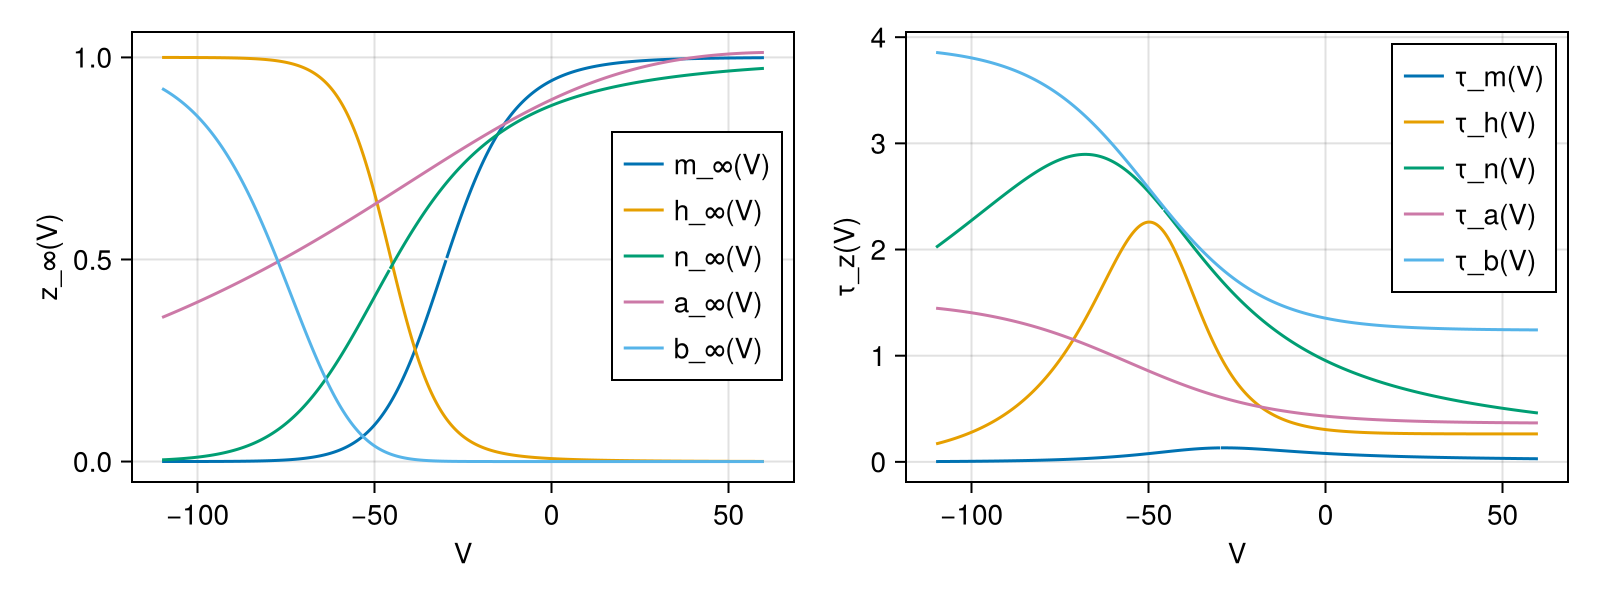

In [3]:
# get gating function from model
f, z_∞, τ_z = connor_stevens(return_gating_functions=true, return_SVector=true)

# plot inf values as function of V
V = -110:0.1:60
fig = Figure(size=(800,300))
ax = Axis(fig[1, 1], xlabel="V", ylabel="z_∞(V)")
z_labels = ["m", "h", "n", "a", "b"]
for (i,z) in enumerate(z_∞)
    lines!(ax, V, z.(V), label="$(z_labels[i])_∞(V)")
end
axislegend(ax, merge=true, unique=true, position=:rc)
# same for τ values in a second plot
ax = Axis(fig[1, 2], xlabel="V", ylabel="τ_z(V)")
for (i,τ) in enumerate(τ_z)
    lines!(ax, V, τ.(V), label="τ_$(z_labels[i])(V)")
end
axislegend(ax, merge=true, unique=true)
fig

In [4]:
using ChaosTools
# get the fixed points
V0 = -70
u0 = hcat(V0, [z(V0) for z in z_∞]...)
system = CoupledODEs(f, u0, [x-> 0, ])
fp,_ = fixedpoints(system, IntervalBox(interval(-80, -60), interval(0,1), interval(0,1), interval(0,1), interval(0,1), interval(0,1)))
print("fixed points: ", fp[1], "\n")
print(typeof(fp[1]))

fixed points: [-67.97811718590123, 0.010069947869040596, 0.965913983231083, 0.15585642961856888, 0.5404229859521252, 0.28866634145071257]
SVector{6, Float64}

[-61.10722395372182, 0.04122734758616702, 0.14195255549875124, 0.709618267876842, 0.7877064906943267, 0.030850709961493097]

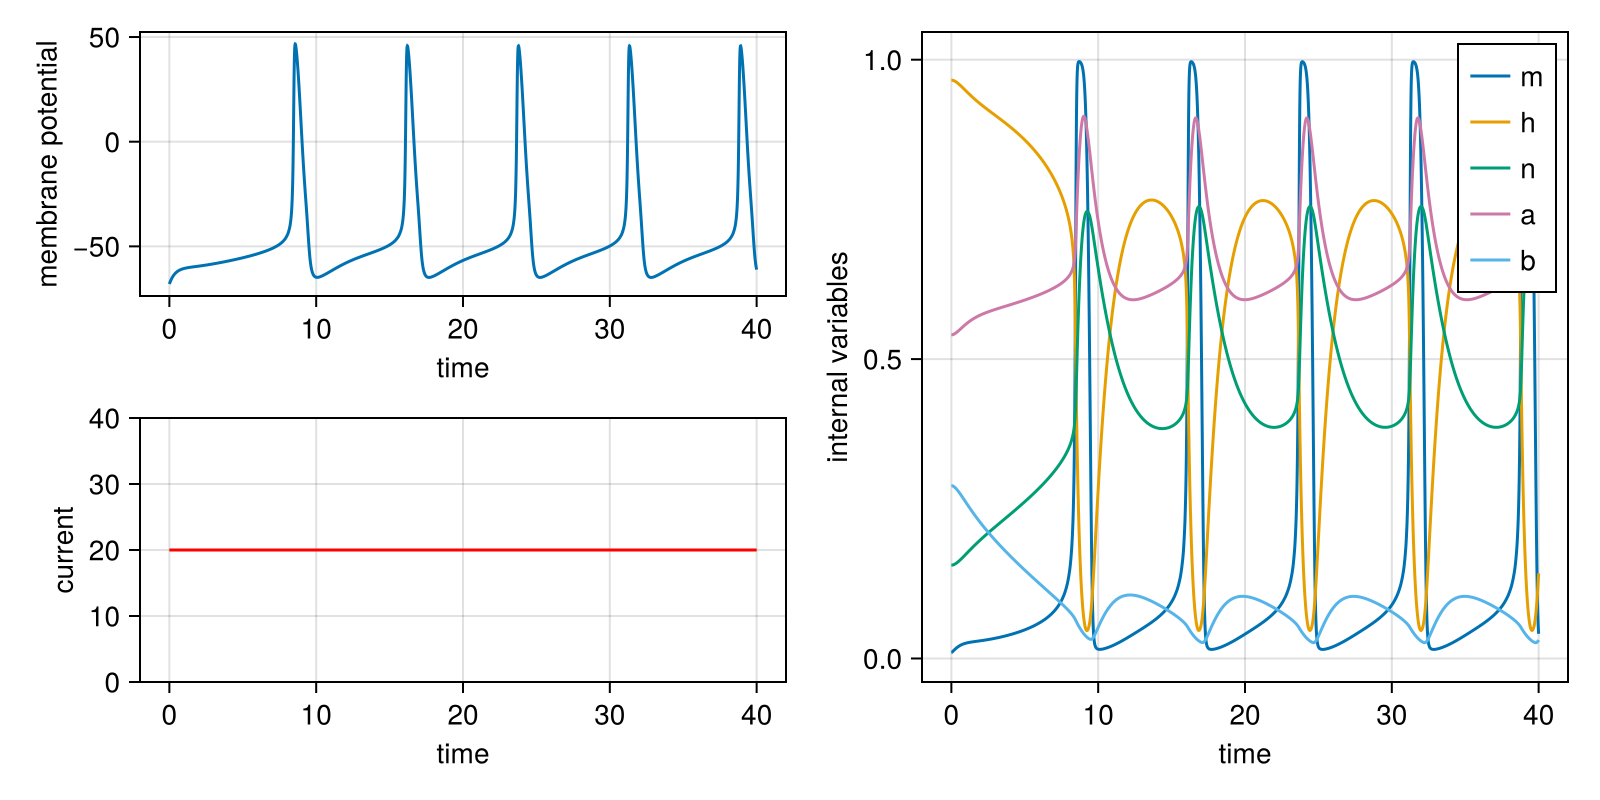

In [5]:
# Benchmark for zero current
u0 = Vector(fp[1])
I_static = 20
prob = ODEProblem(connor_stevens(), u0, (0,40), [t->I_static])
sol = solve(prob, dtmax=1.0, saveat=0.01)
t = sol.t;
v = map(x->x[1], sol.u);
# system = CoupledODEs(connor_stevens(), u0, p0)
# total_time = 40 #ms
# Y, t = trajectory(system, total_time; Dt=Dt)

# figure
fig = Figure(size=(800, 400))
ax = Axis(fig[1, 1]; xlabel="time", ylabel="membrane potential")
I_t = [I_static for t_ in t]
lines!(ax, t, v)
# current
ax = Axis(fig[2, 1]; xlabel="time", ylabel="current")
lines!(ax, t, I_t, color=:red)
# internal variables
ax = Axis(fig[:, 2]; xlabel="time", ylabel="internal variables")
lines!(ax, t, map(x->x[2], sol.u), label="m")
lines!(ax, t, map(x->x[3], sol.u), label="h")
lines!(ax, t, map(x->x[4], sol.u), label="n")
lines!(ax, t, map(x->x[5], sol.u), label="a")
lines!(ax, t, map(x->x[6], sol.u), label="b")
axislegend(ax, merge=true, unique=true)
print(sol.u[end])
fig


In [6]:
# define time-dependent input current
function I_stim(t)
    if 1 < t < 2
        return 0 # 50
    elseif 21 < t < 22
        return 70
    else
        return 0.0
    end
end
# equilibrium values from simulation with zero current
u0 = Vector(fp[1]) + randn(6) * 0.01
# u0 = [-67, 0.04122734758616702, 0.14195255549875124, 0.709618267876842, 0.7877064906943267, 0.030850709961493097]
# u0 = [-67.97750560300683, 0.01007017811593413, 0.965910414853597, 0.1558661552963623, 0.5404265695664189, 0.28864530036215374]

# p0 = [I_stim]
# system = CoupledODEs(connor_stevens(), u0, p0)
# total_time = 400 #ms
# Y, t = trajectory(system, total_time; Dt = Dt)
p = [I_stim,]
prob = ODEProblem(connor_stevens(), u0, (0,300), p)
sol = solve(prob, dtmax=1.0, saveat=0.01)
t = sol.t;
v = map(x->x[1], sol.u);

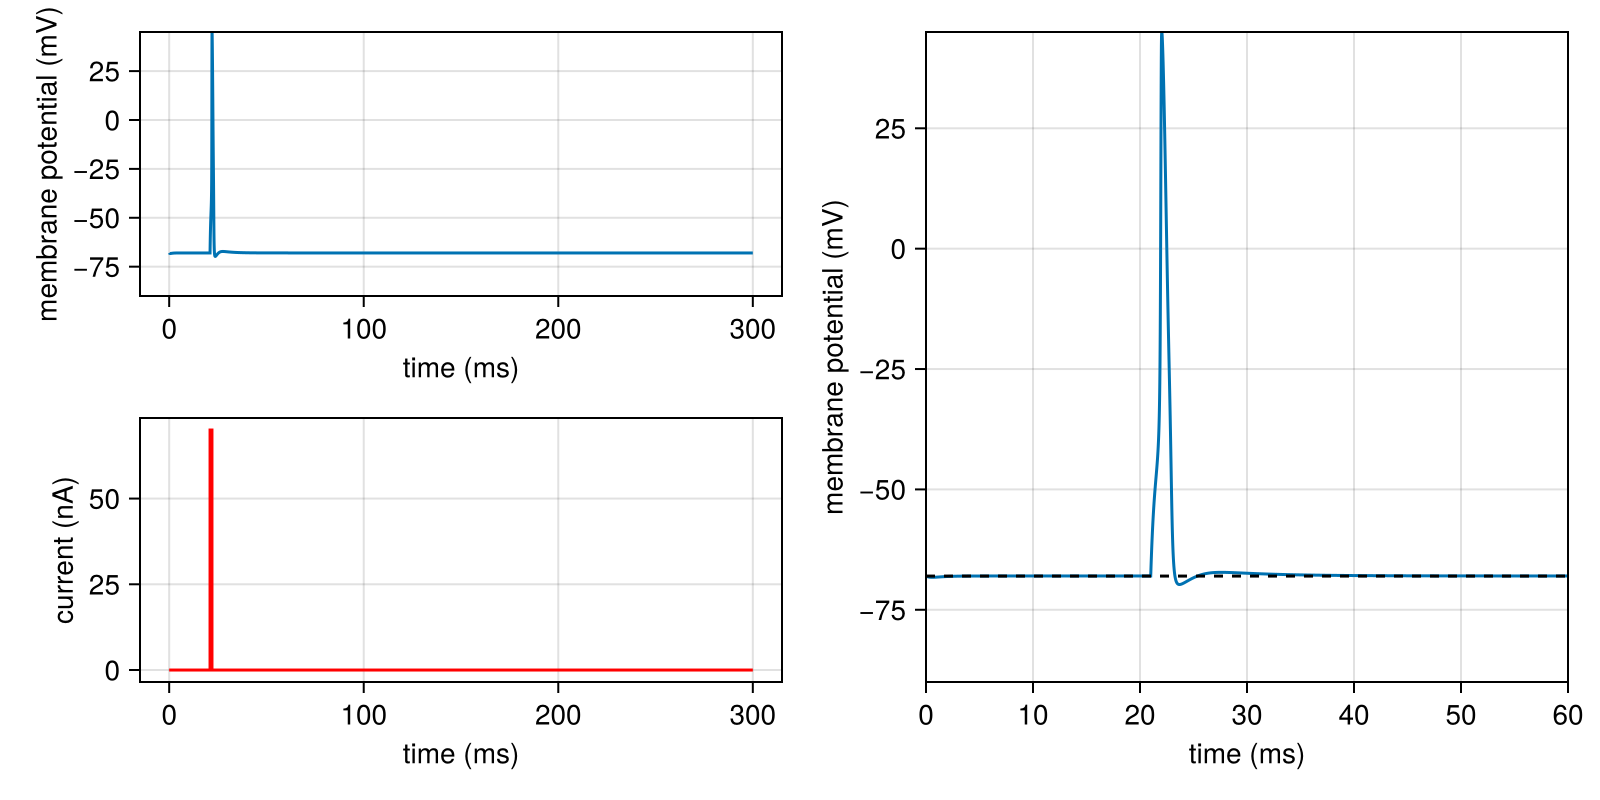

In [7]:
# plot with Makie of time series of membrane potential
# Top: membrane potential
# Bottom: input current
fig = Figure(size = (800, 400))
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "membrane potential (mV)")
lines!(ax, t, v)
ylims!(ax, -90, 45)
# current
ax = Axis(fig[2, 1]; xlabel = "time (ms)", ylabel = "current (nA)")
I_t = [I_stim(t_) for t_ in t]
lines!(ax, t, I_t, color = :red)
# zoom in to the first 50 ms on the right
ax = Axis(fig[:, 2]; xlabel = "time (ms)", ylabel = "membrane potential (mV)")
lines!(ax, t, v)
xlims!(ax, 0, 60)
ylims!(ax, -90, 45)
# plot the resting potential for cortical neurons
hlines!(ax, [-68], color = :black, linestyle = :dash)

fig

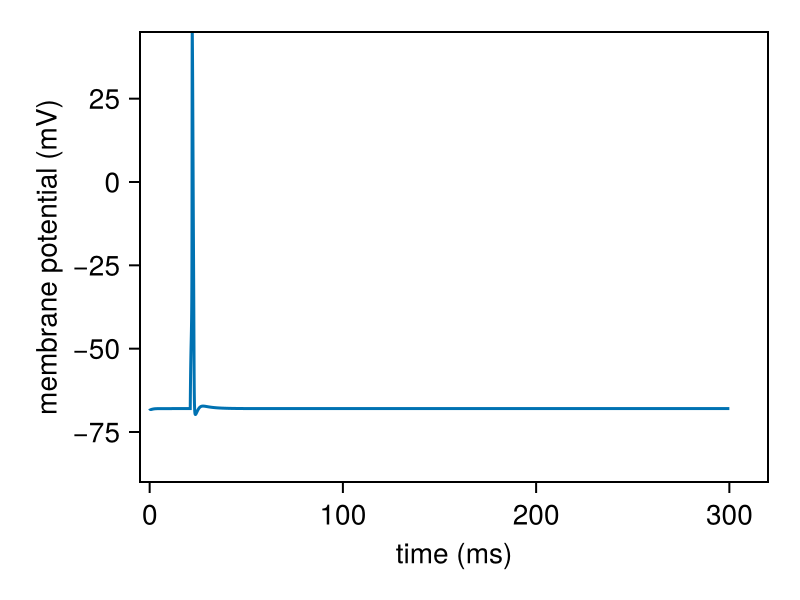

In [8]:
fig = Figure(size = (400, 300))
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "membrane potential (mV)", xgridvisible = false, ygridvisible = false)
# plot non-zero stimulus as gray area in the plot
stimulus_t = t[I_stim.(t) .> 0]
# stimulus_s = [I_stim(t_) for t_ in stimulus_t]
# stimulus_s = (stimulus_s) ./ maximum(stimulus_s)
# vlines!(ax, stimulus_t, ymin=0.0, ymax=0.05*stimulus_s, color = :gray)
#band!(stimulus_t, -100 .* ones(length(stimulus_t)), 50 .* ones(length(stimulus_t)), color = (:gray, 0.8))
# plot membrane potential
lines!(ax, t, v)
# set range
xlims!(ax, -5, 320)
ylims!(ax, -90, 45)
# plot the resting potential for cortical neurons
#hlines!(ax, fp[1][1], color = :black, linestyle = :dash)
# save as pdf
save("../figures/connor_stevens.pdf", fig)
fig